$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
# Implementation of QAOA

In [1]:
from openquantumcomputing.QAOABase import QAOABase
from openquantumcomputing.utilities import *
from openquantumcomputing.mixer_utilities import *
from qiskit.visualization import plot_histogram
from sympy import symbols, expand
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
def reverse_keys(hist):
    hist2 = {}
    for key in hist.keys():
        hist2[key[::-1]] = hist[key]
    return hist2

In [3]:
qasmSim = Aer.get_backend("qasm_simulator") 

$$ H_{cost} = \begin{bmatrix} 
5 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -2 & 0\\
0 & 0 & 0 & 5\\
\end{bmatrix} $$

In [4]:
H_cost = np.diag([5, -1, -2, 5])
display(decompose(H_cost))

dim= 2.0


' + 1.75*II + -0.25*IZ + 0.25*ZI + 3.25*ZZ'

$$ \exp \left(-i\gamma \left(\frac{7}{3}I\otimes I - \frac{1}{4}I\otimes Z + \frac{1}{4}Z\otimes I + \frac{13}{4}Z\otimes Z \right)\right) $$

## Example 1: $H_{mixer} = X\otimes I + I \otimes X$

**initial state** = $\ket{00} + \ket{01} + \ket{10} + \ket{11}$

In [5]:
class QAOA1(QAOABase):
    def cost(self, string, params):
        C = 5
        if string == "01":
            C = -1
        elif string == "10":
            C = -2
        return C

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(2)
        c = ClassicalRegister(2)
        circ = QuantumCircuit(q, c)

        # initial state
        circ.h(q)
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]

            # cost hamiltonian
            circ.rz(-2.*gamma*(1./4.), q[0])
            circ.rz(2.*gamma*(1./4.), q[1])
            circ.rzz(-2.*gamma*(13./4.), q[0], q[1])
   
            # mixer hamiltonian
            circ.rx(-2.*beta, q)

        circ.measure(q, c)
        return circ

In [6]:
display(QAOA1().createCircuit([1.0, 1.0], 1).draw())

┌───┐┌──────────┐           ┌────────┐┌─┐   
q0_0: ┤ H ├┤ Rz(-0.5) ├─■─────────┤ Rx(-2) ├┤M├───
      ├───┤├─────────┬┘ │ZZ(-6.5) ├────────┤└╥┘┌─┐
q0_1: ┤ H ├┤ Rz(0.5) ├──■─────────┤ Rx(-2) ├─╫─┤M├
      └───┘└─────────┘            └────────┘ ║ └╥┘
c0: 2/═══════════════════════════════════════╩══╩═
                                             0  1

In [7]:
qaoa1 = QAOA1()
qaoa1.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -4.86328125


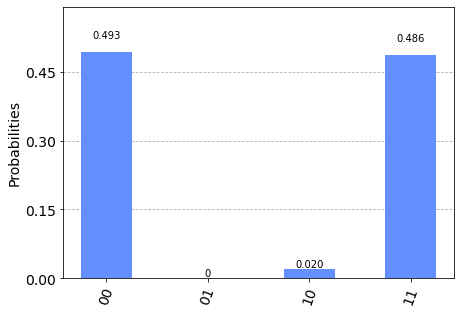

In [8]:
hist1 = qaoa1.hist(angles = qaoa1.angles_hist['d1_final'], backend = qasmSim, shots = 1024)
display(plot_histogram(reverse_keys(hist1)))

## Example 2: $H_{mixer} = \frac{1}{2} \left(X\otimes X + Y \otimes Y \right)$

**initial state** = $\ket{01} + \ket{10}$

In [9]:
class QAOA2(QAOABase):
    def cost(self, string, params):
        C = 5
        if string == "01":
            C = -1
        elif string == "10":
            C = -2
        return C

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(2)
        c = ClassicalRegister(2)
        circ = QuantumCircuit(q, c)

        # initial state
        Wn(circ, [0, 1])
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]

            # cost hamiltonian
            circ.rz(2.*gamma*(1./4.), q[0])
            circ.rz(-2.*gamma*(1./4.), q[1])
            circ.rzz(2.*gamma*(13./4.), q[0], q[1])
               
            # mixer hamiltonian
            circ.rxx(-beta, q[0], q[1])
            circ.ryy(-beta, q[0], q[1])
            
            
        circ.measure(q, c)
        return circ

In [10]:
display(QAOA2().createCircuit([1.0, 1.0], 1).draw())

┌───┐┌───┐┌─────────┐           ┌──────────┐┌──────────┐┌─┐   
q5927_0: ┤ X ├┤ X ├┤ Rz(0.5) ├──■────────┤0         ├┤0         ├┤M├───
         ├───┤└─┬─┘├─────────┴┐ │ZZ(6.5) │  Rxx(-1) ││  Ryy(-1) │└╥┘┌─┐
q5927_1: ┤ H ├──■──┤ Rz(-0.5) ├─■────────┤1         ├┤1         ├─╫─┤M├
         └───┘     └──────────┘          └──────────┘└──────────┘ ║ └╥┘
 c430: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                  0  1

In [11]:
qaoa2 = QAOA2()
qaoa2.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= 1.001953125


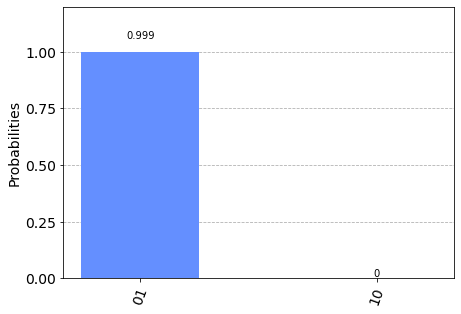

In [12]:
hist2 = qaoa2.hist(angles = qaoa2.angles_hist['d1_final'], backend = qasmSim, shots = 1024)
display(plot_histogram(reverse_keys(hist2)))

## Example 3: penalty hamiltonian

$$ H_{penalty} = \begin{bmatrix} 
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & \lambda\\
\end{bmatrix} $$

$$ \exp \left(-\gamma \frac{\lambda}{4}\left(I\otimes I - Z \otimes I - I \otimes Z + Z \otimes Z \right)\right) $$


**initial state**: $\ket{00} + \ket{01} + \ket{10} + \ket{11}$

In [13]:
class QAOA3(QAOABase):
    def cost(self, string, params):
        C = 5
        if string == "01":
            C = -1
        elif string == "10":
            C = -2
        return C

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(2)
        c = ClassicalRegister(2)
        circ = QuantumCircuit(q, c)

        # initial state
        circ.h(q)
        
        lmbda = -10.0
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]

            # cost hamiltonian
            circ.rz(-2.*gamma*(1./4.), q[0])
            circ.rz(2.*gamma*(1./4.), q[1])
            circ.rzz(-2.*gamma*(13./4.), q[0], q[1])
            
            # penalty hamiltonian
            circ.rz(2.*gamma*lmbda*(1./4.), q[0])
            circ.rz(2.*gamma*lmbda*(1./4.), q[1])
            circ.rzz(-2.*gamma*lmbda*(1./4.), q[0], q[1])
               
            # mixer hamiltonian
            circ.rx(-2.*beta, q)

        circ.measure(q, c)
        return circ

In [14]:
display(QAOA3().createCircuit([1.0, 1.0], 1).draw())

┌───┐┌──────────┐           ┌────────┐        ┌────────┐┌─┐   
q13324_0: ┤ H ├┤ Rz(-0.5) ├─■─────────┤ Rz(-5) ├─■──────┤ Rx(-2) ├┤M├───
          ├───┤├─────────┬┘ │ZZ(-6.5) ├────────┤ │ZZ(5) ├────────┤└╥┘┌─┐
q13324_1: ┤ H ├┤ Rz(0.5) ├──■─────────┤ Rz(-5) ├─■──────┤ Rx(-2) ├─╫─┤M├
          └───┘└─────────┘            └────────┘        └────────┘ ║ └╥┘
  c859: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                   0  1

In [15]:
qaoa3 = QAOA3()
qaoa3.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -4.890625


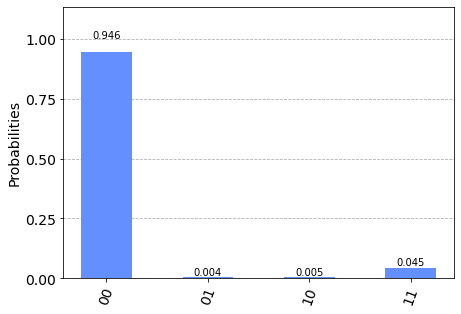

In [16]:
hist3 = qaoa3.hist(angles = qaoa3.angles_hist['d1_final'], backend = qasmSim, shots = 1024)
display(plot_histogram(reverse_keys(hist3)))

## Example 4: penalty from constraint term

**initial state**: $\ket{00} + \ket{01} + \ket{10} + \ket{11}$

In [17]:
g = get_g(["10", "01", "00"])
expr = g[1]
for i, symbol in enumerate(g[0]):
    Z_i = symbols(f"Z{i}")
    expr = expr.subs(symbol, 0.5*(1.0 - Z_i))
display(expand(expr))

0.5*Z0*Z1 - 0.5*Z0 - 0.5*Z1 + 0.5

In [18]:
class QAOA4(QAOABase):
    def cost(self, string, params):
        C = 5
        if string == "01":
            C = -1
        elif string == "10":
            C = -2
        return C

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(2)
        c = ClassicalRegister(2)
        circ = QuantumCircuit(q, c)

        # initial state
        circ.h(q)
        
        lmbda = -4.0
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]

            # cost hamiltonian
            circ.rz(-2.*gamma*(1./4.), q[0])
            circ.rz(2.*gamma*(1./4.), q[1])
            circ.rzz(-2.*gamma*(13./4.), q[0], q[1])
            
            # constraint hamiltonian
            circ.rz(2.*gamma*lmbda*(1./2.), q[0])
            circ.rz(2.*gamma*lmbda*(1./2.), q[1])
            circ.rzz(-2.*gamma*lmbda*(1./2.), q[0], q[1])
               
            # mixer hamiltonian
            circ.rx(-2.*beta, q)

        circ.measure(q, c)
        return circ

In [19]:
display(QAOA4().createCircuit([1.0, 1.0], 1).draw())

┌───┐┌──────────┐           ┌────────┐        ┌────────┐┌─┐   
q19997_0: ┤ H ├┤ Rz(-0.5) ├─■─────────┤ Rz(-4) ├─■──────┤ Rx(-2) ├┤M├───
          ├───┤├─────────┬┘ │ZZ(-6.5) ├────────┤ │ZZ(4) ├────────┤└╥┘┌─┐
q19997_1: ┤ H ├┤ Rz(0.5) ├──■─────────┤ Rz(-4) ├─■──────┤ Rx(-2) ├─╫─┤M├
          └───┘└─────────┘            └────────┘        └────────┘ ║ └╥┘
 c1287: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                   0  1

In [20]:
qaoa4 = QAOA4()
qaoa4.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -4.8974609375


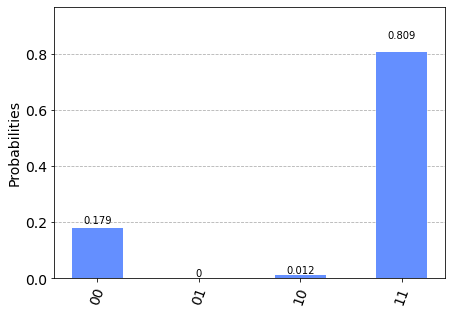

In [21]:
hist4 = qaoa4.hist(angles = qaoa4.angles_hist['d1_final'], backend = qasmSim, shots = 1024)
display(plot_histogram(reverse_keys(hist4)))

## Example 5: penalty in cost function

$$ H_{cost} = \begin{bmatrix} 
5 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -2 & 0\\
0 & 0 & 0 & 5\\
\end{bmatrix} +
\begin{bmatrix} 
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & \lambda\\
\end{bmatrix} $$

**initial state**: $\ket{00} + \ket{01} + \ket{10} + \ket{11}$

In [22]:
class QAOA5(QAOABase):
    def cost(self, string, params):
        lmbda = params.get("lmbda")
        if string == "00":
            C = 5
        elif string == "01":
            C = -1
        elif string == "10":
            C = -2
        else:
            C = 5 + lmbda
        return C

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(2)
        c = ClassicalRegister(2)
        circ = QuantumCircuit(q, c)

        # initial state
        circ.h(q)
        
        lmbda = params.get("lmbda")
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]

            # cost hamiltonian
            circ.rz(-2.*gamma*(1./4.), q[0])
            circ.rz(2.*gamma*(1./4.), q[1])
            circ.rzz(-2.*gamma*(13./4.), q[0], q[1])
            
            # constraint hamiltonian
            circ.rz(2.*gamma*lmbda*(1./4.), q[0])
            circ.rz(2.*gamma*lmbda*(1./4.), q[1])
            circ.rzz(-2.*gamma*lmbda*(1./4.), q[0], q[1])
            
            # mixer hamiltonian
            circ.rx(-2.*beta, q)

        circ.measure(q, c)
        return circ

In [23]:
params = {"lmbda" : -4.0}
display(QAOA4().createCircuit([1.0, 1.0], 1, params = params).draw())

┌───┐┌──────────┐           ┌────────┐        ┌────────┐┌─┐   
q26734_0: ┤ H ├┤ Rz(-0.5) ├─■─────────┤ Rz(-4) ├─■──────┤ Rx(-2) ├┤M├───
          ├───┤├─────────┬┘ │ZZ(-6.5) ├────────┤ │ZZ(4) ├────────┤└╥┘┌─┐
q26734_1: ┤ H ├┤ Rz(0.5) ├──■─────────┤ Rz(-4) ├─■──────┤ Rx(-2) ├─╫─┤M├
          └───┘└─────────┘            └────────┘        └────────┘ ║ └╥┘
 c1719: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                   0  1

In [24]:
qaoa5 = QAOA5()
qaoa5.increase_depth(backend = qasmSim, precision = 0.25, params = params)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -4.40625


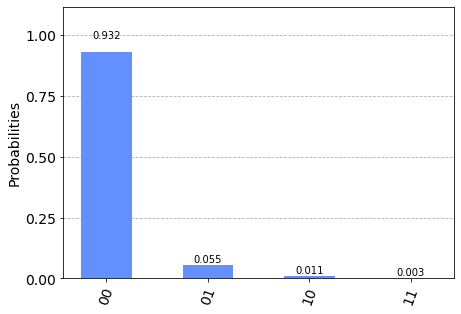

In [25]:
hist5 = qaoa5.hist(angles = qaoa5.angles_hist['d1_final'], backend = qasmSim, shots = 1024, params = params)
display(plot_histogram(reverse_keys(hist5)))